Goal is to minimize J(θ), θ in R^p

- theta is the position of the bacterium
- J(θ) represents the combined effects of attractants and repellants from the environment
    - J(θ) < 0 -->  bacterium at location θ is in nutrient-rich
    - J(θ) = 0 --> neutral 
    - J(θ) > 0 --> noxious environment



chemotactic step : tumble+tumble OR tumble+run

- j : index for chemotactic step
- k : index for reproduction step
- l : index for elimination-dispersal event

Let P(j,k,l) represent the position of each member in the population ofthe S bacteria at the jth chemotactic step, kth reproduction step, and lth elimination-dispersal event.

**P(j,k,l) = {θ^i(j,k,l) | i=1,2,...,S}**

Let J(i,j,k,l) denote the cost at the location of the ith bacterium.

Let N_c be the length of the lifetime of the bacteria as measured by the number of chemotactic steps they take during their life.

Let C(i) > 0, i=1,2,...,S denote a basic chemotactic step size that we will use to define the lengths of steps during runs. 

To represent a tumble, a unit length random direction, say φ(j), is generated; this will be used to define the direction of movement after a tumble. 

**θ^i(j+1,k,l) = θ^i(j,k,l) + C(i)*φ(j)***

The above ^^ discussion was for the case where no
cell-released attractants are used to signal other cells that
they should swarm together.

With cell-to-cell signaling via an attractant then, we will represent that
with 

**J^i_cc(θ, θ^i(j,k,l)), i S= 1 2, , ,K**
 for the ith bacterium


Let **d_attract = 0.1** be the depth of the attractant released by the cell (a quantification of how much attractant is released)

Let **w_attract = 0.2** be a measure of the width of the attractant signal (a quantification of the diffusion rate of the chemical)

The cell also repels a nearby cell in the sense that it consumes nearby nutrients and it is not physically possible to have two cells at the same location. To model this, we 

Let **h_repellant = d_attract** be the height of the repellant effect (magnitude of its effect)

Let **w_reppelant = 10** be the width of the repellant

In [8]:
import numpy as np
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

BEGIN
 Initialize randomly the bacteria foraging optimization population
 Calculate the fitness of each agent
 Set global best agent to best agent
 FOR number of iterations
  FOR number of chemotactic steps
   FOR each search agent
    Move agent to the random direction
    Calculate the fitness of the moved agent
    FOR swimming length
     IF current fitness is better than previous
      Move agent to the same direction
     ELSE
      Move agent to the random direction
     END IF
    END FOR
   END FOR
   Calculate the fitness of each agent
  END FOR
  Compute and sort sum of fitness function of all chemotactic loops (health of agent)
  Let live and split only half of the population according to their health
  IF not the last iteration
   FOR each search agent
    With some probability replace agent with new random generated
   END FOR
  END IF
  Update the best search agent
 Calculate the fitness of each agent
END

In [2]:
# function for the nutrition landscape, (pretty arbitrary), global min at (2, 0)
def landscape(x, y):
    return (x-3) ** 2 + y ** 2
# multimodal function with many local minima, but one global min at (0, 0)
def ackley(x, y):
    return -20*np.e**(-0.2*np.sqrt(0.5*(x**2+y**2)))-np.e**(0.5*(np.cos(2*np.pi*x)+np.cos(2*np.pi*y)))+20+np.e

In [3]:
class E_coli:
    def __init__(self, r, angle, stepsize, landscape):
        self.r = r
        self.angle = np.radians(angle)
        self.stepsize = stepsize
        self.position = np.asarray([[r * np.cos(self.angle)],
                                    [r * np.sin(self.angle)]])
        self.health = 0
        self.x_s = []
        self.y_s = []
        self.landscape = landscape
        self.get_fitness()

    def run(self):
        # print('RUN!')
        unit_vector = np.asarray([[1],
                                  [1]])
        rotation_matrix = np.asarray([[np.cos(self.angle), -np.sin(self.angle)],
                                      [np.sin(self.angle), np.cos(self.angle)]])

        displacement_vector = self.stepsize*np.matmul(rotation_matrix, unit_vector)

        self.position = np.add(self.position, displacement_vector)
        self.get_fitness()
        
    def tumble(self):
        # print('TUMBLE!')
        random_angle = np.random.randint(-120, 120)
        self.angle += np.radians(random_angle)
        self.run()

    def get_fitness(self):
        self.x = self.position[0, 0]
        self.y = self.position[1, 0]
        self.fitness = self.landscape(self.x, self.y)
        self.health += self.fitness
        self.x_s.append(self.x)
        self.y_s.append(self.y)

In [4]:
class BFO:
    def __init__(self, population_size, num_iterations, chemotactic_steps, swimming_length, replace_probability, landscape):
        self.landscape = landscape
        self.population = np.asarray([E_coli(np.random.uniform(1, 10),np.random.uniform(0, 360), swimming_length, self.landscape) for i in range(population_size)])
        self.global_best = None
        self.num_iterations = num_iterations
        self.replace_probability = replace_probability
        self.chemotactic_steps = chemotactic_steps
        self.swimming_length = swimming_length
        
    def update_swarm(self):
        for e_coli in self.population:
            e_coli.tumble()
            prev_fitness = e_coli.fitness
            for i in range(self.chemotactic_steps):
                if e_coli.fitness < prev_fitness:
                    e_coli.run()
                else:
                    e_coli.tumble()
        self.get_best()
                
    def run_simulation(self):
        for i in range(self.num_iterations):
            self.update_swarm()
            sorted_population = sorted(self.population, key=lambda x: x.fitness)
            better_half = sorted_population[:len(self.population)//2]
            new_population = better_half + better_half
            self.population = self.dispersal_elimination(new_population)
        self.get_best()

    def dispersal_elimination(self, population_in):
        population_out = [E_coli(np.random.uniform(1, 10),np.random.uniform(0, 360),
                        self.swimming_length, self.landscape) if np.random.randint(0, 3) == 0 else i for i in population_in ]        
        
        return population_out
        
    def get_best(self):
        sorted_population = sorted(self.population, key=lambda x: x.fitness)
        self.global_best = sorted_population[0]

    def visualize(self):
        x_s = self.global_best.x_s
        y_s = self.global_best.y_s

        x1 = np.linspace(-2, 2, 10)
        x2 = np.linspace(-2, 2, 10)
        X1, X2 = np.meshgrid(x1, x2)
        Z = ackley(X1, X2)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle('RESULTS OF THE BACTERIA SWARM OPTIMIZATION')
        ax1.scatter(x_s, y_s)

        contours = ax2.contour(X1, X2, Z, 20)
        ax2.clabel(contours, inline = True, fontsize = 10)
        plt.title("Evolution of the cost function during the run of the best* e_coli with level circles", fontsize=7)
        ax2.plot(x_s, y_s)
        ax2.plot(x_s, y_s, '*', label = "E.coli")
        plt.xlabel('x', fontsize=11)
        plt.ylabel('y', fontsize=11)
        # plt.colorbar()
        plt.legend(loc = "upper right")
        plt.show()
        
        x_s = self.global_best.x_s
        y_s = self.global_best.y_s
        # creating figure
        fig = plt.figure()
        ax = Axes3D(fig)
        auto_add_to_figure=False
        fig.add_axes(ax)
        
        # creating the plot
        plot_geeks = ax.scatter(x_s, y_s, [ackley(x_s[j], y_s[j]) for j in range(len(x_s))], color='red')
        
        # setting title and labels
        ax.set_title("3D plot")
        ax.set_xlabel('x-axis')
        ax.set_ylabel('y-axis')
        ax.set_zlabel('z-axis')
        
        # displaying the plot
        plt.show()

INITIAL X :  -1.5783243802306244
INITIAL Y :  -0.5475781531876176
TERMINAL X :  -0.01739670675682055
TERMINAL Y :  -0.013549681429897719


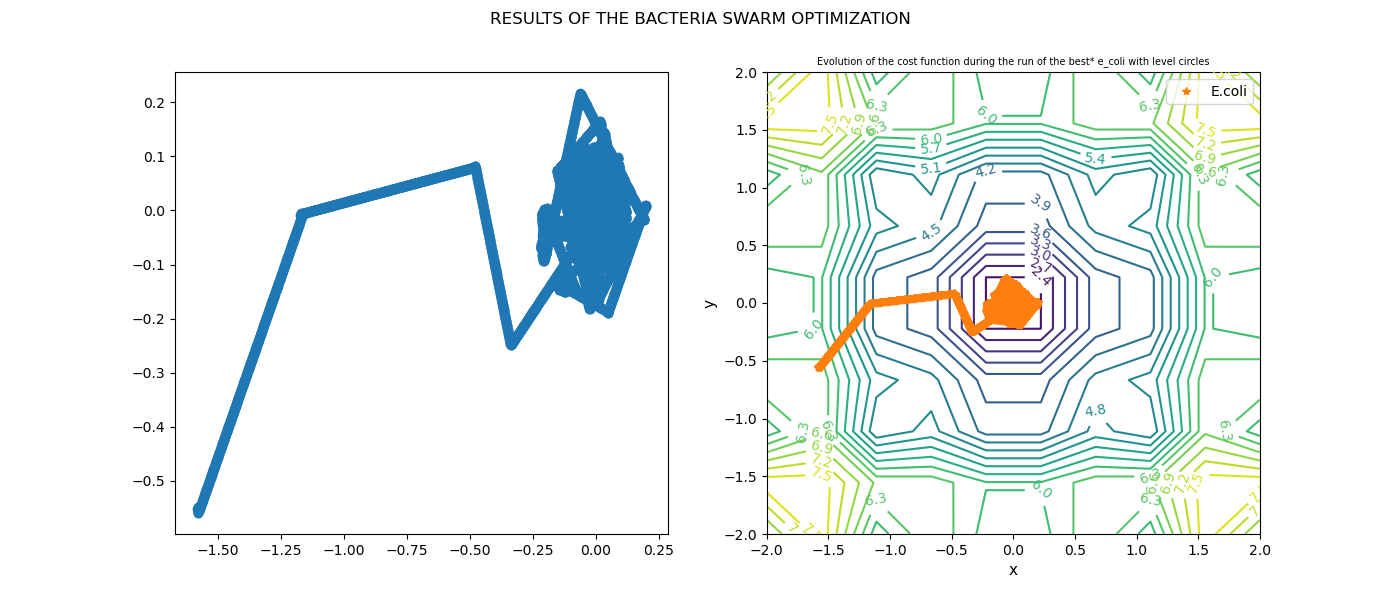

/tmp/ipykernel_4159/1469836880.py:69: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


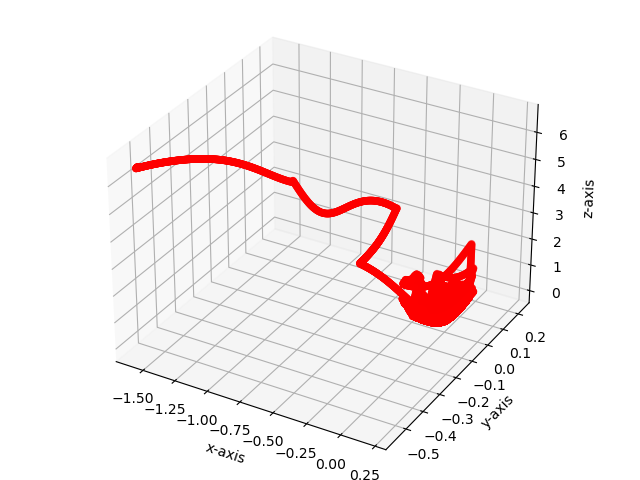

In [9]:
bfo = BFO(population_size=100, num_iterations=10, chemotactic_steps=500, swimming_length=0.001, replace_probability=0.25, landscape=ackley)
bfo.run_simulation()
print('INITIAL X : ',bfo.global_best.x_s[0])
print('INITIAL Y : ',bfo.global_best.y_s[0])

print('TERMINAL X : ',bfo.global_best.x)
print('TERMINAL Y : ',bfo.global_best.y)

%matplotlib widget
bfo.visualize()